<h1><center>Graded practical work (12h)</center></h1>

# INTRODUCTION

### Objective

Set up a simple yet effective POMDP model in order to drive human-machine interaction in the Firefighter Robot Game study case. 

![POMDP_for_HRI.png](figures/POMDP_for_HRI.png)

This POMDP model will be based on a dataset that has been collected during an experiment and that is provided to you.

### Recall: the POMDP model

If you need a reminder about POMDPs definitions and algorithms get a look into **"Recalling_POMDPs.ipynb"**

### Provided library
The PyPOMDP library (see https://github.com/namoshizun/PyPOMDP) is provided with this notebook. 

This library proposes two state-of-the-art algorithms, PBVI and POMCP (do not hesitate to get a look in the Caroline's slides courses). However, this library has been customized with several additional features that will be very useful for this practical work.

For instance, the library now save a Value Function parametrized by $\alpha$-vectors, in a file. This can be then reloaded to simulate the policy in order to evaluate futur gains, or in order to replay an experiment.

In this practical work course we will mainly use the implementation of PBVI.

# THE FIREFIGTHER ROBOT GAME

## Experiments conduted in the lab
During lab experiments, 18 volunteers equipped with physiological sensors have played the Firefigther Robot Game.
http://robot-isae.isae.fr

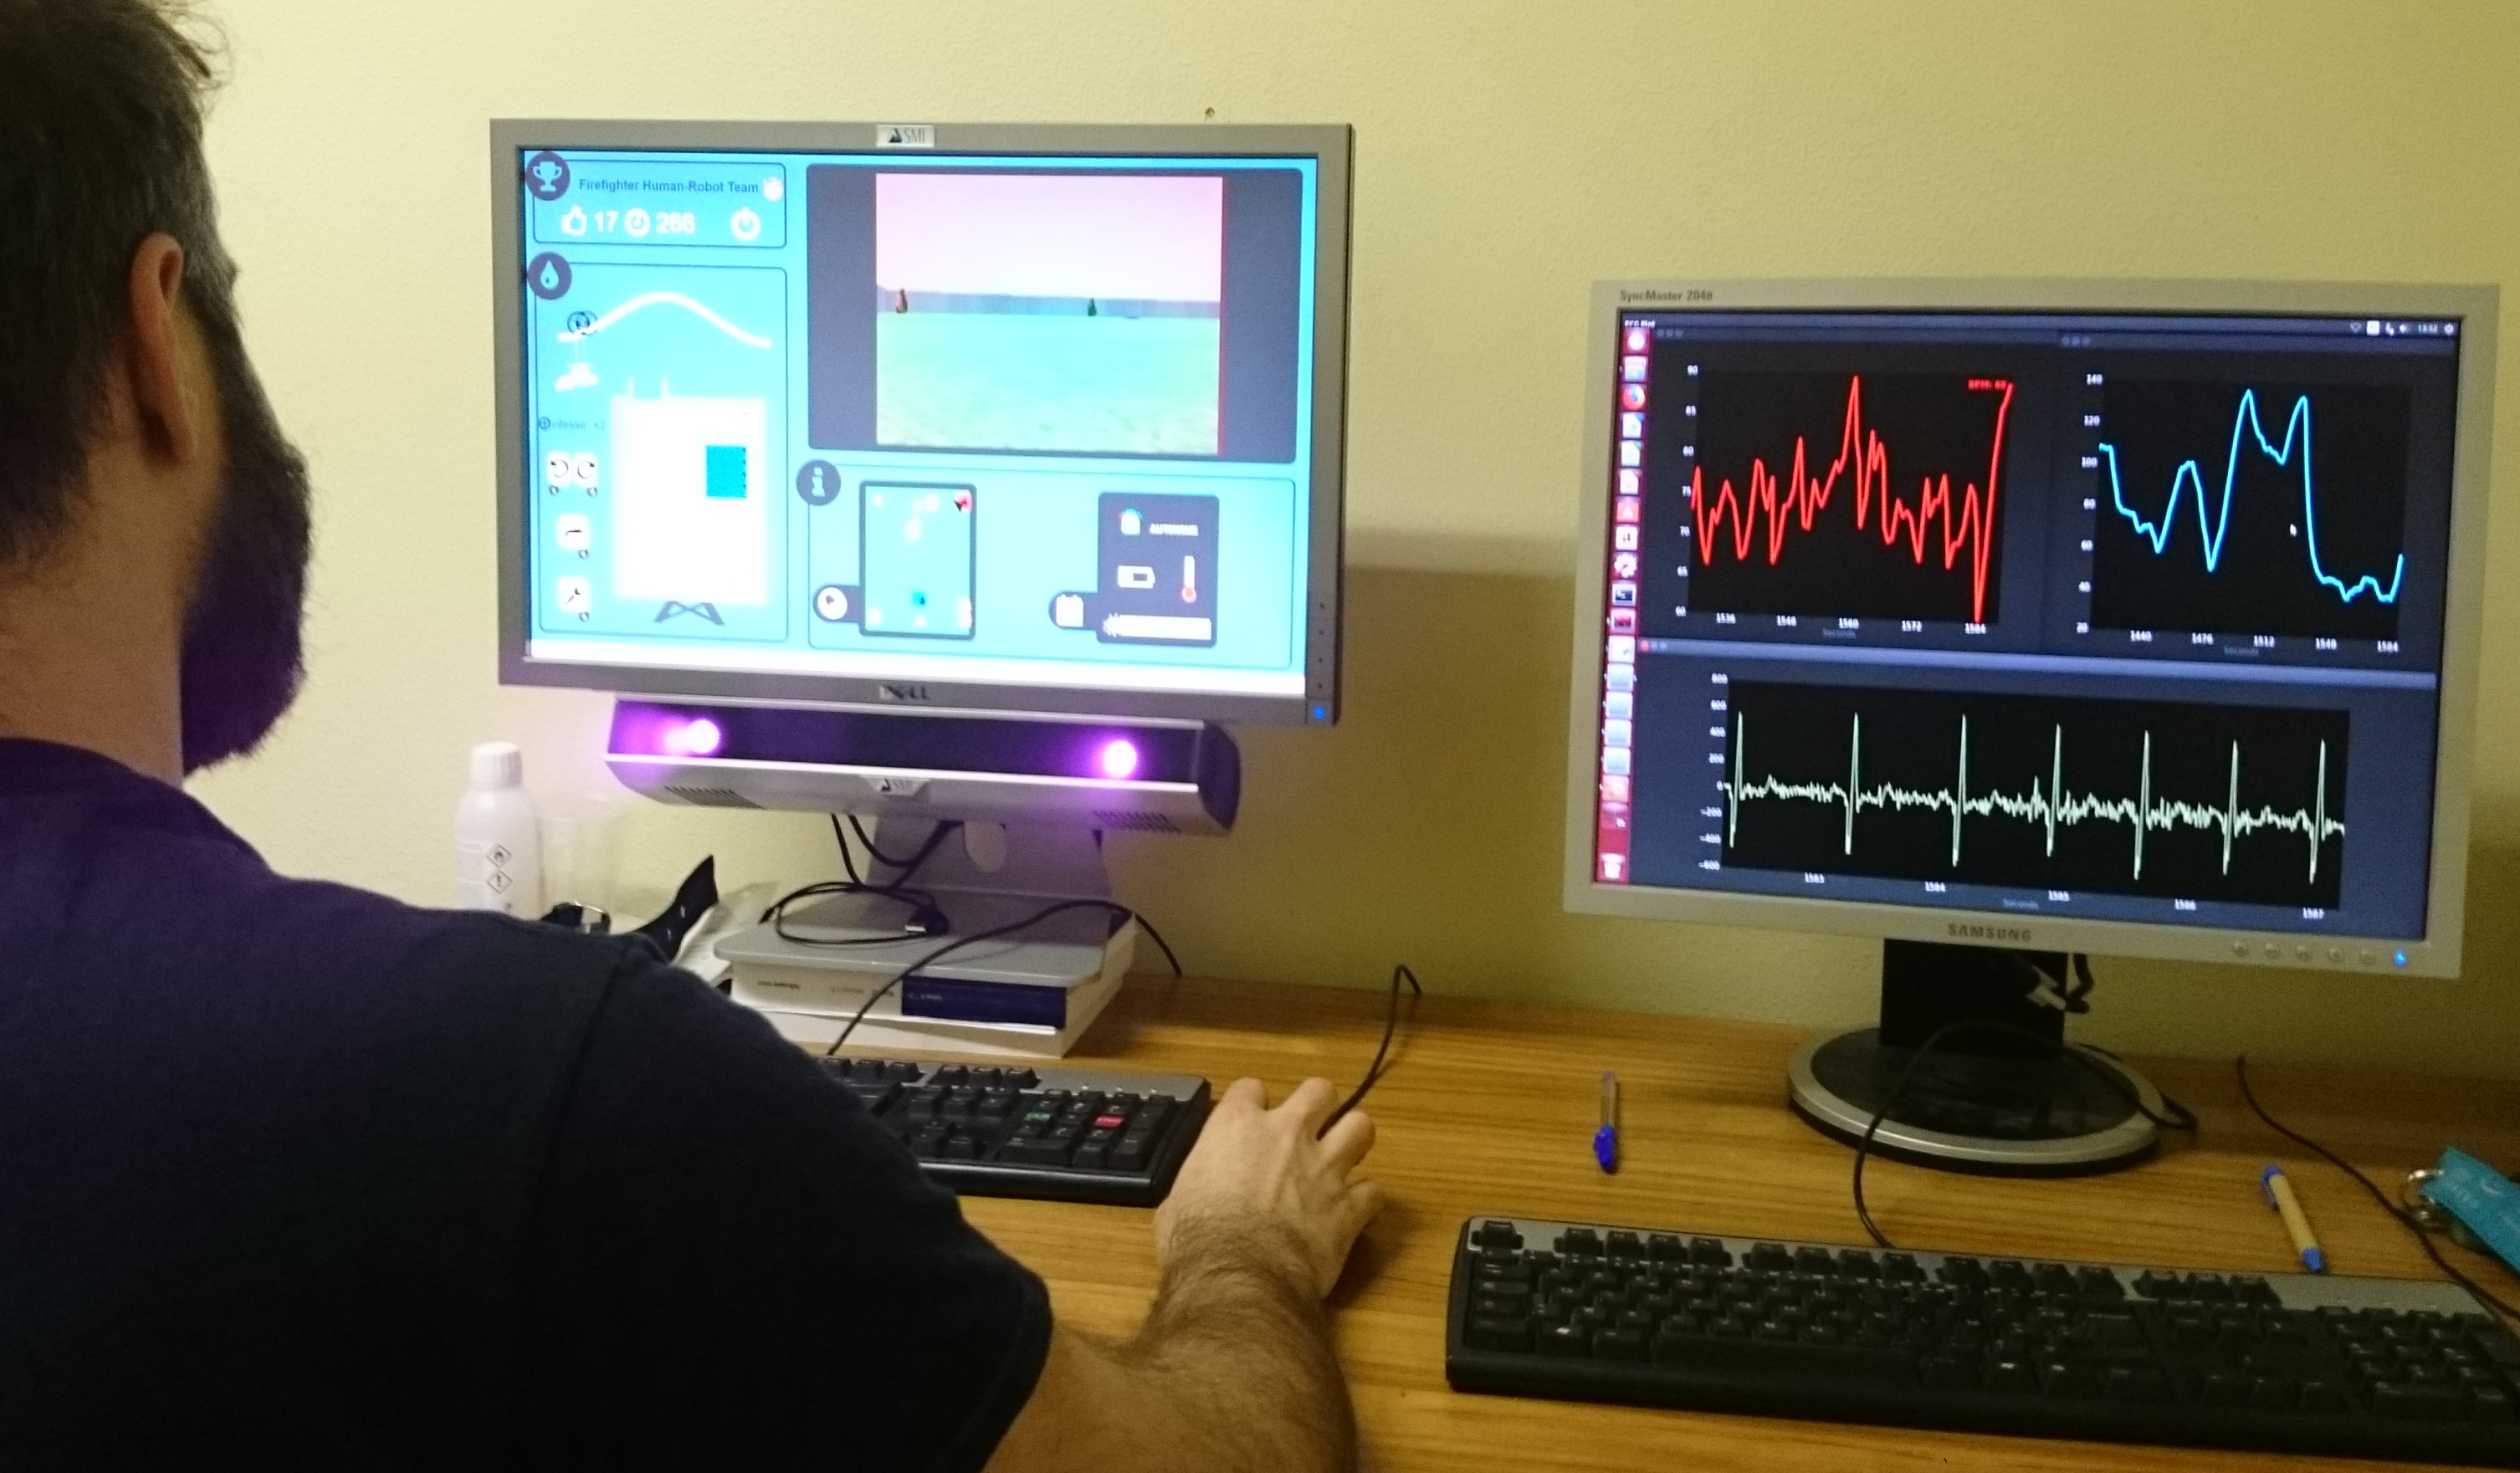

Each participant followed an experimental protocol in which 4 missions are played. Please see the FireFigther game presentation for more details.

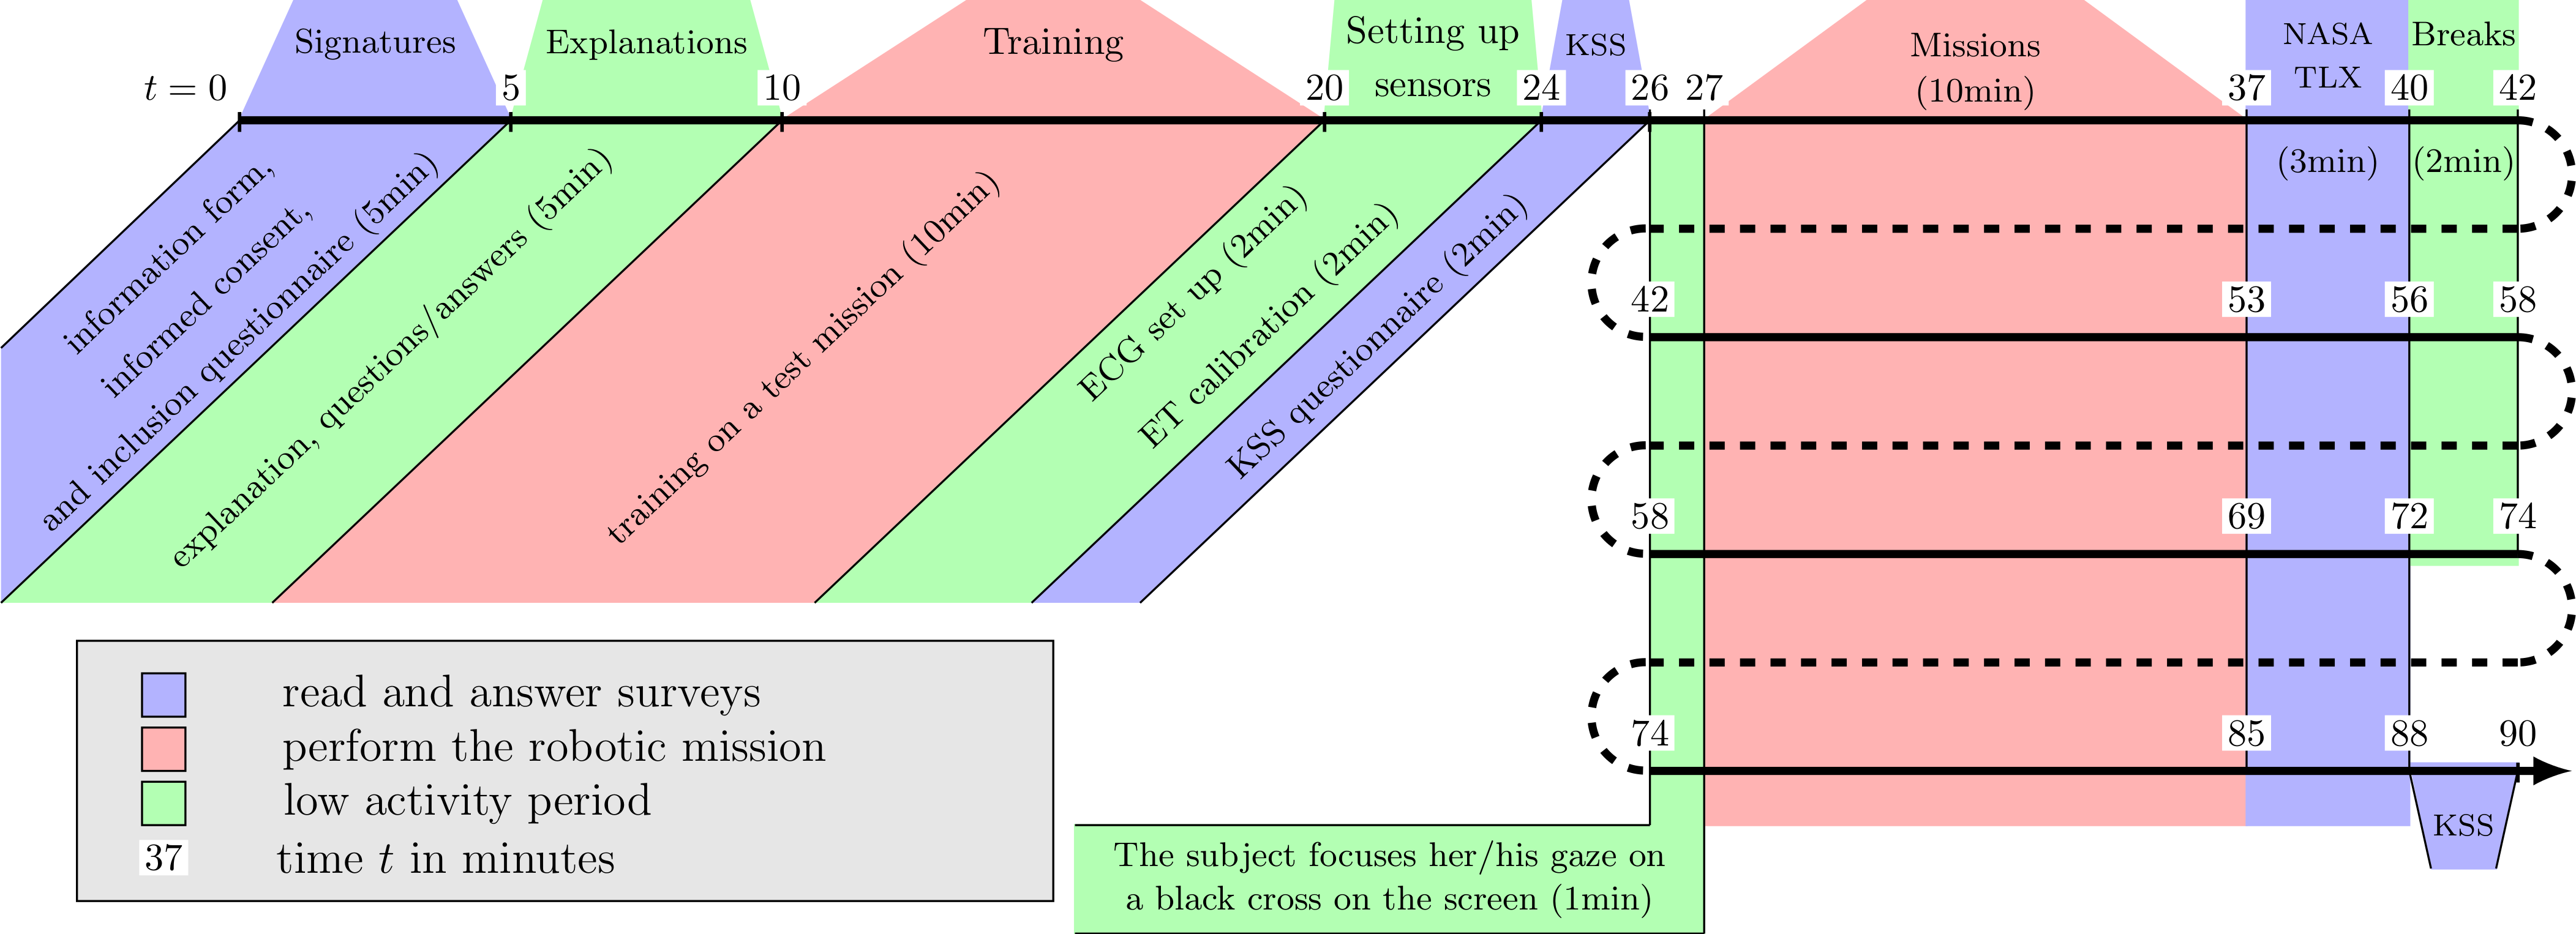


## Mission scoring 

The number of extinguished fires allowed to quantify how well a mission has been performed. We could define two performance group using the median score as a threshold to obtain a balanced dataset. Each mission was then labeled as: 0 for low scoring mission group (low performance); and 1 for high scoring mission group (high performance).


## Datasets

Two datasets are provided:
1. A labeled dataFrame including preprocessed markers for each 10-second time window, mission and participant
2. A labeled dataFrame gathering **averaged markers** results for each 10-second time window, mission, participant and robot operation mode


In [2]:
import pandas as pd
import numpy as np

# example :
# importing label dataset including preprocessed markers for each 10-second time window, mission and participant
# this dataset will be useful for classification purposes
df10labeled_data = pd.read_csv('./data/df10labeled_data.csv')
print(df10labeled_data)

# example:
# importing labeled dataset with averaged or summed markers results for each 
# 10-second time window, mission, participant and robot operation mode
averagedPMPVmode_w10_data = pd.read_csv('./data/averagedPMPVmode_w10_data.csv')
print(averagedPMPVmode_w10_data)


      subject  mission  mode         HR       HRV   nav  tank  space  trees  \
0        19.0      1.0   0.0  72.568940 -0.066819  14.0   0.0    0.0    0.0   
1        19.0      1.0   0.0  74.229865 -0.087446  18.0   2.0    0.0    0.0   
2        19.0      1.0   1.0  73.304826 -0.070724   9.0   5.0    0.0    0.0   
3        19.0      1.0   1.0  69.962687 -0.050697   0.0   8.0    0.0    0.0   
4        19.0      1.0   1.0  70.771408 -0.076950   0.0   7.0    0.0    1.0   
...       ...      ...   ...        ...       ...   ...   ...    ...    ...   
3586     40.0      4.0   1.0  69.767442 -0.041904   0.0  24.0    0.0    0.0   
3587     40.0      4.0   0.0  67.046597 -0.043276  12.0   8.0    0.0    0.0   
3588     40.0      4.0   0.0  69.549090 -0.044936  10.0  14.0    0.0    0.0   
3589     40.0      4.0   0.0  72.245635 -0.045260   6.0   8.0    1.0    0.0   
3590     40.0      4.0   1.0  71.564885 -0.048838   2.0   9.0    0.0    0.0   

      nbAOI1  ...  nbAOI4  nbAOI5  durAOI1   durAOI

### Markers description
* **subject** : identification number of the participant
* **mission** : identification number of the mission (1, 2, 3 or 4)
* **mode** : robot operation mode (0 for manual, 1 for autonomous)
* **HR** : average of the participant's heart-rate (on the 10sec window) 
* **normHR** : normalized participant's heart-rate (w.r.t. the rest period)
* **HRV** : normalized heart-rate variability (w.r.t. the rest period)
* **nav** : total number of keystrokes and cliks related with robot navigation control task in the 10sec window.
* **tank** : total number of  keystrokes/clicks realted with the external tank management task in the 10sec window.
* **space** : total number of times the space key was pressed in the 10sec window.
* **trees** : total number of trees on fire that are extinghised using the space keyboard in the 10sec window.
* **nbAOI1** : total number of eye fixations in the AOI (Areas-Of-Interest) number 1 (same for the others).
* **durAOI1** : total duration of fixations performed in the AOI number 1 (same for the others)
* **tank_local_score** : how much the external tank level has increased/decreased in the last 10s.
* **nbt_trees_mode** : total number of extinguished trees per operation mode
* **label**: {0,1} boolean indicating if the final mission score is good (1) or bad (0). Note that in this work we will consider that it reflects the mental state of the human operator: 1 for $e$ (engaged / performant) and 0 for $ne$ (not engaged / not performant).

# PRACTICAL WORK TASKS

## Task 1 : Defining the POMDP model 

As our goal is to drive (i.e. control) the interaction between the human operator and the robot in function of the human operator engagement (cf. presentation):

1. We define the state space as $S = S_h$, where $S_h = \{e, ne\}$, to express the human partially observable mental state of (a correct) engagement ($e$) or the absence of (a correct) engagement ($ne$). Note that this last mental state encapsulates disengaged and over-engaged cases, in which participants performed badly.
2. We define the action space as $A = \{manual, auto\}$, representing the possible decisions of our POMDP agent about which robot operation mode (manual or autonomous mode) should be used.
3. We define the observation space as $\Omega =  \{oe, one\}$, that are the possible predictions of a classifier trained to detect human engagement based on available behavioral and physiological data.

The transition function is defined as $p(s, a, s') = Pr(s' \mid s,a) = \left \{ \begin{array}{cc} 1 - \epsilon & \mbox{if } s=s'\\ \epsilon & \mbox{ otherwise } \end{array} \right.$. Note that the dynamics of the operator engagement in the task is rougly approached using the fact that an "engaged" human operator remains "engaged" with a small probability ($\epsilon$) for changing its mental state to "not engaged".

**It will be your job to define of the observation $o()$ and the reward $r()$ functions. For that, you may make use of the provided behavioral and physiological data.**

We notice that the time step $t$ in our POMDP model refers to a 10-second time window. In other words, the POMDP agent plays an action every 10s.

### Task 1.1 : Define the POMDP observation function

To achieve this step, proceed by chosing features and use them to train and test a classifier. 

The output of this classifier will be the prediction (observation) about the human operator engagement based on data. As explained, ET, ECG and HAI markers are provided. **It is your job to choose which markers are relevant to be used as features.**

In order to check on markers relevance, we suggest you perform decriptive and statistical analysis.

#### Task 1.1.1: Descriptive data analysis

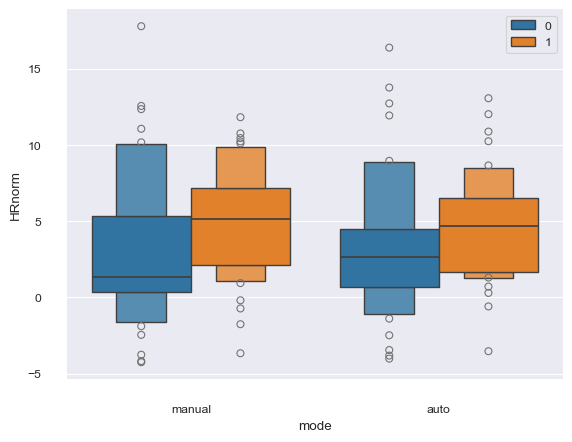

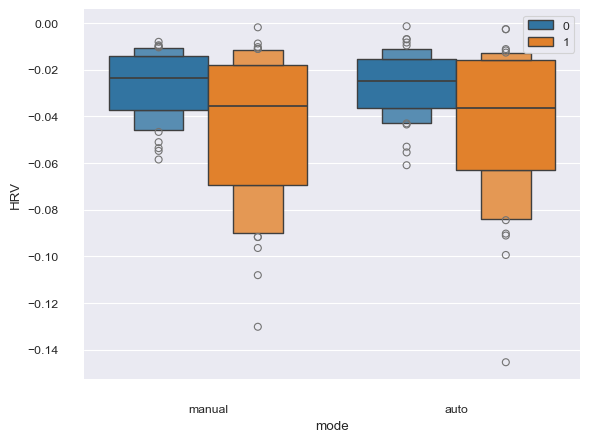

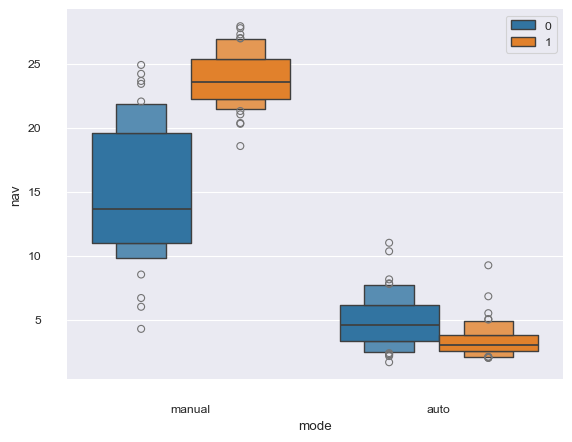

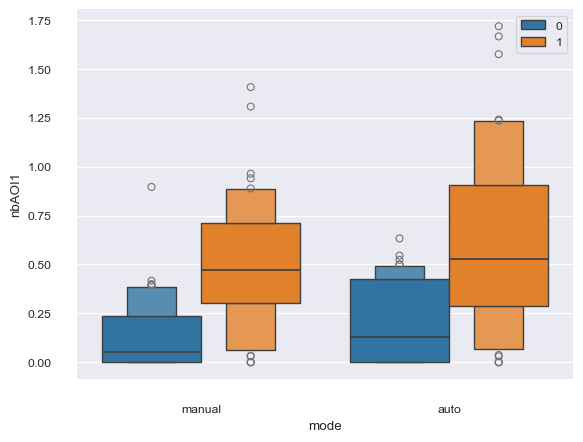

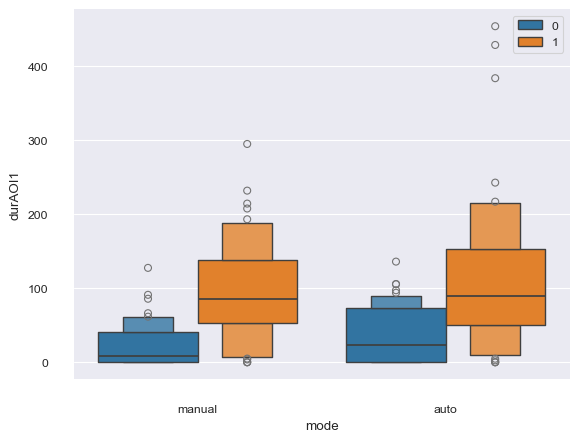

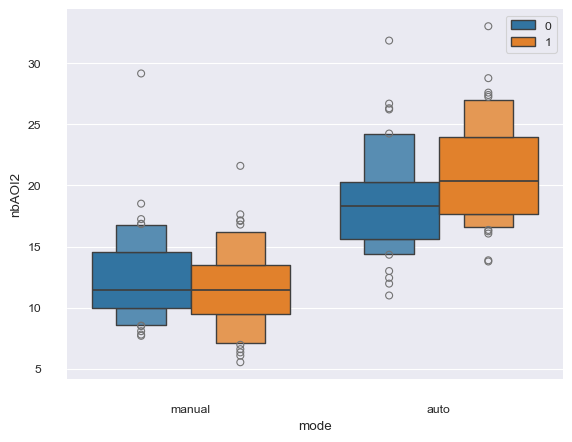

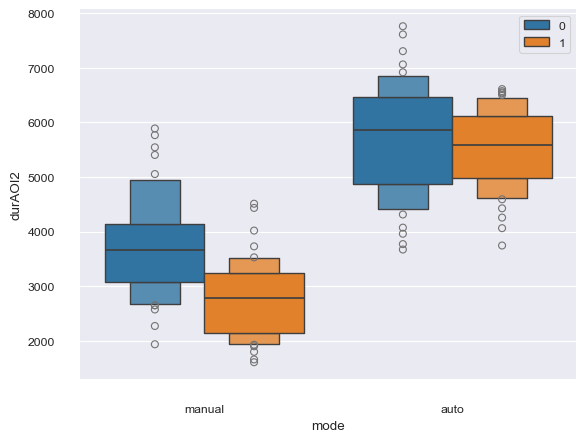

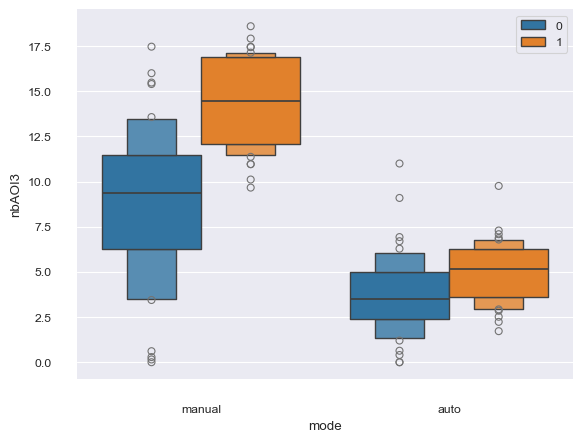

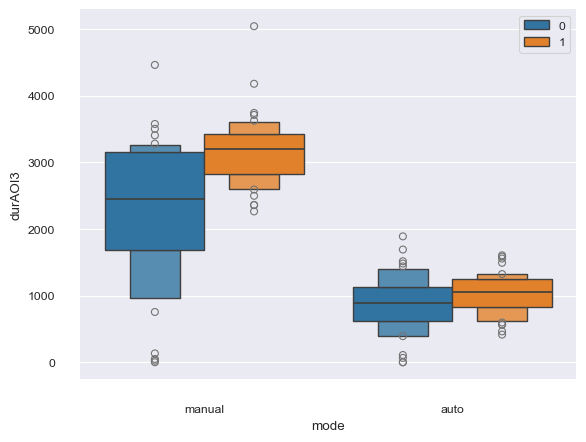

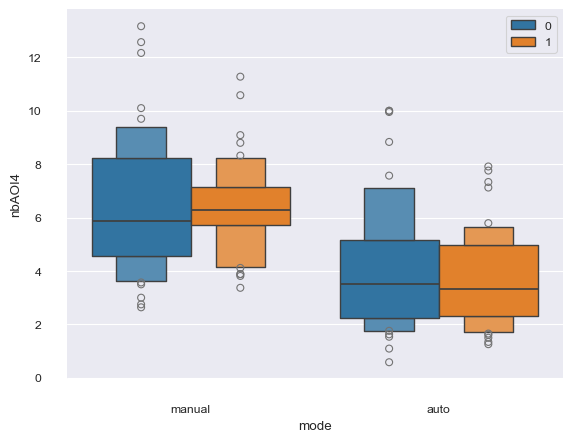

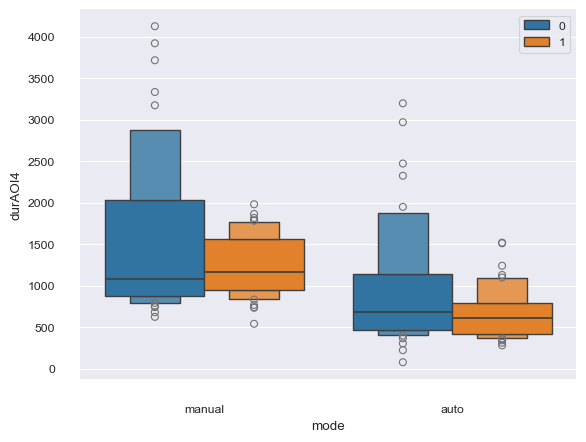

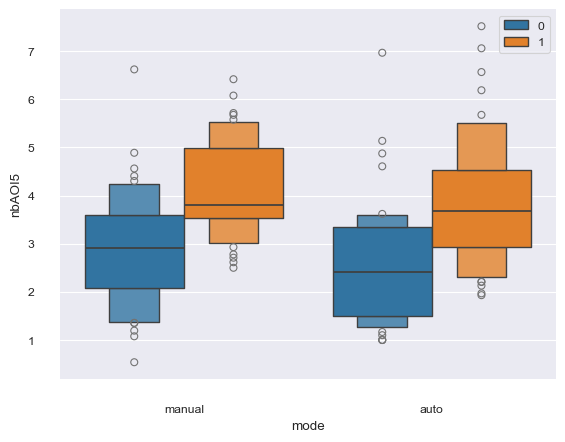

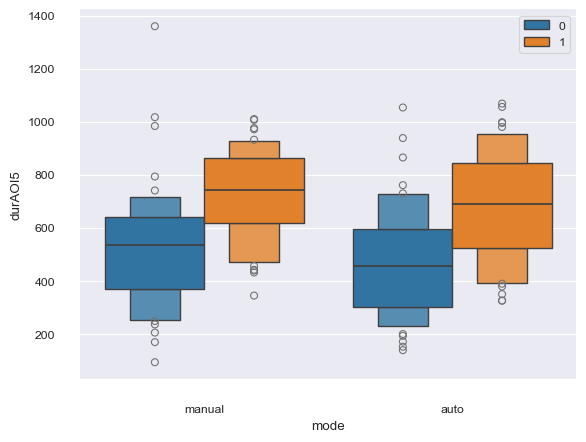

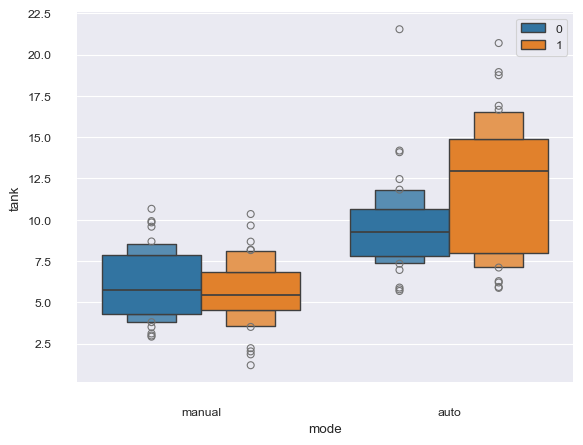

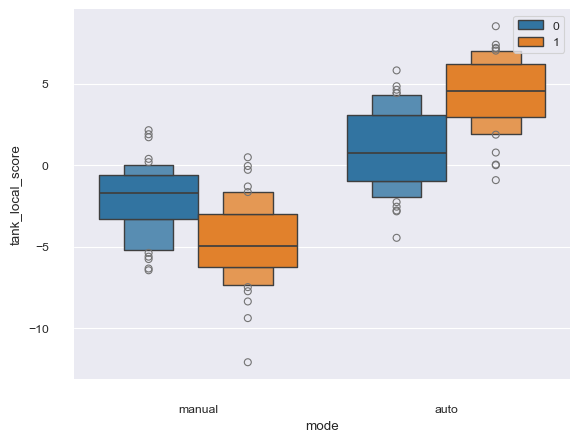

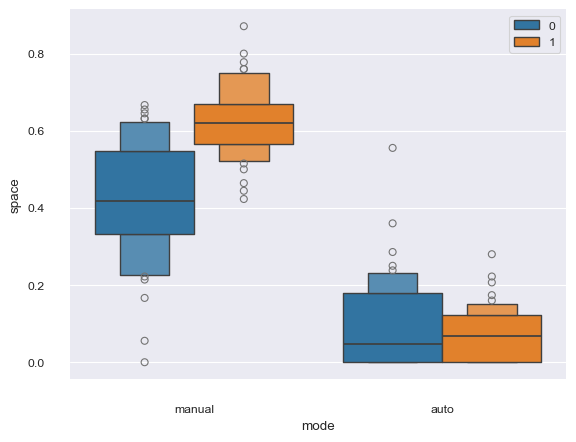

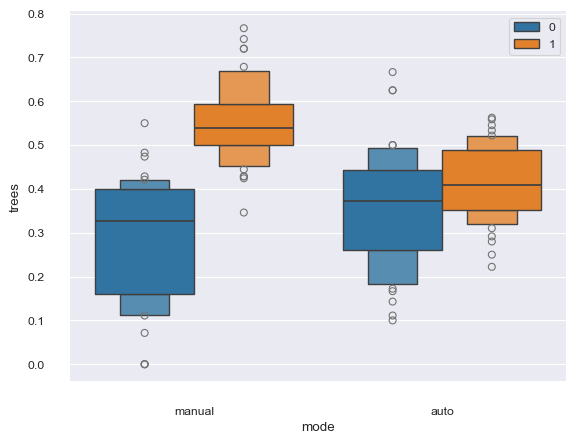

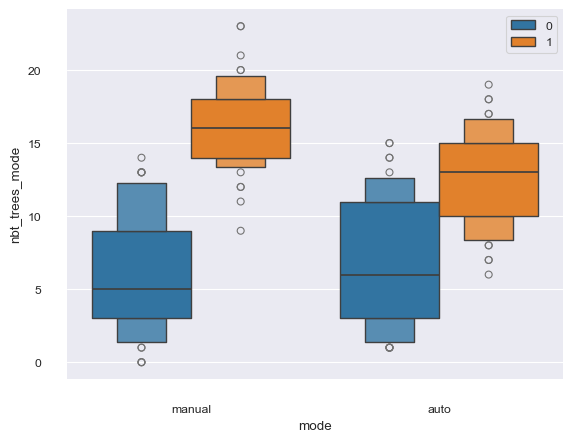

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

######################################################################
### Defining some useful plotting function for you
def plotting_data_per_mode(data, xstr, ystr):
    palette=sorted(sns.color_palette("BuGn", 10), reverse=True)
    palette = [palette[6], palette[9]]
    sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})
    sns.boxenplot(x=xstr, y=ystr, hue="mode", palette=palette, linewidth=1, data=dfaveraged_data)
    #plt.ylim([-1, 30])
    plt.xticks([0, 1], ['low scores group', 'high scores group'])
    sns.despine(offset=10, trim=True)
    plt.legend(loc='best')
    
def plotting_data_per_perfgroup(data, xstr, ystr):
    palette=sorted(sns.color_palette("BuGn", 10), reverse=True)
    palette = [palette[6], palette[9]]
    sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})
    #sns.boxenplot(x=xstr, y=ystr, hue="label", palette=palette, linewidth=1, data=dfaveraged_data)
    sns.boxenplot(x=xstr, y=ystr, hue="label", linewidth=1, data=dfaveraged_data)
    #plt.ylim([-1, 30])
    plt.xticks([0, 1], ['manual', 'auto'])
    sns.despine(offset=10, trim=True)
    plt.legend(loc='best')
    plt.show()
    

#######################################################################
# importing data
dfaveraged_data = pd.read_csv('./data/averagedPMPVmode_w10_data.csv')

## Plotting display examples
## Note these plots represent quantiles of the quantitative variables
## plotting operation mode x HRnorm grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "HRnorm")
plt.show()

## plotting operation mode x HRV grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "HRV")
plt.show()
#plt.clf()

## plotting operation mode x nav keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nav")
plt.show()
#plt.clf()

## plotting operation mode x nbAOI1 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI1")
plt.show()

## plotting operation mode x durAOI1 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "durAOI1")
plt.show()


## plotting operation mode x nbAOI2 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI2")
plt.show()

## plotting operation mode x durAOI2 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "durAOI2")
plt.show()


## plotting operation mode x nbAOI3 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI3")
plt.show()

## plotting operation mode x durAOI3 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "durAOI3")
plt.show()
 
## plotting operation mode x nbAOI4 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI4")
plt.show()

## plotting operation mode x durAOI4 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "durAOI4")
plt.show()

## plotting operation mode x nbAOI5 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI5")
plt.show()

## plotting operation mode x durAOI5 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "durAOI5")
plt.show()

## plotting operation mode x tank keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "tank")
plt.show()

## plotting operation mode x tank_local_score keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "tank_local_score")
plt.show()

## plotting operation mode x space keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "space")
plt.show()

## plotting operation mode x trees keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "trees")
plt.show()

## plotting operation mode x nbt_trees_mode keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbt_trees_mode")
plt.show()

#### Draw conclusions for task 1.1.1 here:


- AOI1 : Score / timer
- AOI2 : Tank
- AOI3 : Retour caméra
- AOI4 : Map
- AOI5 : Paramètres robot

Les marqueurs les plus pertinents pour entrainer notre classifieur sont ceux présentent des valeurs significativement différentes entre les groupes de bonnes performances et de basses performances.
Concernant l'impact du mode de jeu (manuel ou auto), il peut être intéressant de prendre en compte la variabilité du marker en fonction du mode mais cela n'est pas un critère de choix prédominant.

Par conséquent, au vu des médianes et des écarts types obtenus pour chaque marqueur moyenné, nous choisissons dans un premier temps les marqueurs nav, nbAOI1, nbAOI3 et nbAOI5.


**HRnorm** : Plus élevé en cas de réussite, mais peut-être pas significatif pour discriminer correctement les groupes. 

**HRV** : Plus grande variabilité sur le groupe 1 pour les deux modes, et un HRV moyen plus faible en cas de réussite. HRV ainsi que HRnorm sont liés à l'état de stress, mais aussi à l'état d'engagement, quelque soit sa nature. HRV étant en moyenne plus élevée et HRnorm plus faibles en cas de réussite, cela pourrait traduire un niveau d'engagement plus élevé, sans pour autant refléter un état de stress.

**Nav** : critère discriminant autant en auto qu'en manuel où il y a un écart significatif entre le groupe 0 et 1 :
Dans le mode manuel, les participants qui réussissent se déplacent davantage. 
En revanche, dans le mode auto, l'activité des touches de déplacement est en moyenne plus faible en cas de réussite. Il se peut que le groupe qui réussit remarque plus vite le passage en mode auto et minimise ses actions "inutiles", pour se concentrer sur d'autres tâches, ce qui contribue de plus à ne pas interférer avec les plans du robot. Il se peut également que ce soit un choix volontaire des participants de ne pas laisser le robot faire comme bon lui semble, en mode auto, qui nuise aux performances.



**NBAOI1** et **durAOI1** : En mode manuel comme auto, les participants qui réussissent observent davantage et plus souvent le score et le timeur. Cela peut traduire un engagement plus intense dans la tâche à réaliser. De plus, que ce soit en cas de réussite ou d'échec, cette zone de l'écran est légèrement plus regardée en mode auto. Il se peut qu'avoir une tâche de moins à gérer (AOI3) libère du temps/de la charge mentale pour observer le timer et le score, plus souvent et plus longtemps.

**NBAOI2** et **durAOI2** : Cette zone est en moyenne beaucoup plus observée et plus longtemps en mode auto. En effet, comme pour AOI1, il se peut qu'avoir une tâche de moins à gérer (AOI3) libère du temps/de la charge mentale pour gérer le remplissage du réservoir, plus souvent et plus longtemps. En mode manuel, les participants obtenant des échecs observent en moyenne davantage (pas plus souvent mais plus longtemps) le tank. C'est assez étonnant, mais c'est peut être la conséquence d'une attention plus (trop) faible portée sur le retour caméra et l'extinction concrète des feux.  Ces deux critères semblent surtout discrimant entre les deux modes. 

**NBAOI3** et **durAOI3** : Très logiquement, cette zone est bien plus observée en mode manuel qu'en mode auto. De manière logique avec les données de l'action clavier, ceux qui réussissent observent plus cette zone, et plus longtemps. Il aurait cependant pu être possible que tous en mode manuel observent aussi longtemps cette zone, mais que ceux qui échouent ne prennent simplement pas assez de décisions de mouvement. Il semblerait ainsi que les décisions de mouvements (moins élevée chez ceux qui échouent) ne sont pas liés à une observation trop passive de la zone, mais plutôt à un plus fort désintérêt pour le suivi sur cette zone d'intérêt. Que ce soit parce que l'attention être trop focalisée sur une autre zone (erreur stratégique) ou parce que le participant est désengagé. Ces critères sont très discriminants concernant la réussite en mode manuel, mais assez peu en mode automatique. 

**NBAOI4** et **durAOI4** : Critères peu discriminants. La map est tout de même moins observée en mode auto, ce qui est logique puisque l'on a plus à se déplacer soi-même, donc moins besoin de se situer

**NBAOI5** et **durAOI5** : Les participants qui réussissent observent plus et plus longtemps la zone indiquant les paramètres de jeux. Cela permet de détecter au plus tôt lorsque l'on doit reprendre la main sur le déplacement (passage en manuel), et lorsqu'on peut arrêter de s'en occuper et se concentrer sur le remplissage (passage en auto). La valeur moyenne en cas de réussite et d'échec est semblable dans le mode manuel et dans le mode auto. C'est ce à quoi ou pourrait s'attendre car la relation est symétrique : il est tout aussi important de regarder cette zone lorsqu'on est en mode manuel qu'en mode auto. 
Etonnament, cette zone est très légèrement moins observée en mode auto qu'en mode manuel, que ce soit en cas de réussite ou d'échec. On pourrait s'attendre à ce qu'elle soit davantage observée car le participant a davantage le "temps" de le faire, puisqu'il n'a pas à gérer le déplacement. Pour tenter d'expliquer l'effet contraire, on peut émettre l'hypothèse qu'en mode auto, le participant est vraiment focus sur une seule tâche, le remplissage du tank, et en "oublie" de regarder autour. D'autant plus que AOI2 est relativement loins de AOI5, là ou AOI3 était plus proche, donc il était peut être plus simple pour l'oeil de donner de brefs coups d'oeils aux paramètres en mode manuel, ou l'on regarde davantage AOI3. Cela ne serait pas contradictoire avec le fait qu'on observe légèrement plus AOI1 en mode auto, car justement dans ce mode, AOI2 est davantage observé, et il est plus proche d'AOI1 que ne l'est AOI3. 

**tank** : Significativement plus élevé en mode auto, de manière logique. En mode manuel, les deux groupes de participants on appuyé globalement de manière identique. Par contre, en mode auto, les participants qui ont réussit ont bien plus appuyé sur les touches permettant de recharger le tank. Ils ont potentiellement été bien moins passifs pendant la phase auto. Ceux qui ont échoués, ont justement peut être échoué parce qu'ils ne remplissaient pas (ou pas assez) leur tank, notamment même quand ils n'avaient que cette tâche à gérer. Ce critère semble très discriminant, entre les modes, et surtout au sein du mode manuel.

**tank_local_score** : En mode auto, le niveau du tank augmente pour les deux groupes, alors qu'il diminue pour les deux groupes en mode manuel. En effet, premièrement l'attention est portée globalement davantage sur le déplacement dans le parc, donc on peut en oublier de remplir le tank. Deuxièmement, puisqu'en manuel on se focus sur éteindre les feux, on consomme de l'eau donc cela réduit le niveau du tank. En aubserve que le niveau diminue davantage chez ceux qui réussisse qu'il ne diminue chez ceux qui échouent. On peut faire l'hypothèse qu'il diminue car ceux qui réussissent éteignent les feux, donc consomment de l'eau, là ou ceux qui échouent en éteignent moins, et consomment ainsi moins d'eau. Finalement, pour ceux qui échouent, la valeur varie relativement peu entre les modes, à la différence de ceux qui réussissent, où elle varie beaucoup. Ce critère semble assez fortement discriminant.

**space** : La touche est très peu pressée en mode auto, mais beaucoup plus en mode manuel, notamment chez ceux qui réussissent. C'est donc un critère bien discriminant. En mode manuel, cette donnée est quasi semblable à **trees**, à la différence près qu'on peut presser la touche sans éteindre le feu, par exemple s'il on a plus d'eau, mais c'est peu perceptible sur les données. En mode auto des arbres sont éteints par action humaine à peut près dans les mêmes proportions en moyenne dans les deux groupes. Cependant, les valeurs sont très dispersées chez ceux qui échouent : certains éteignent bien plus de feux manuellement que ceux qui réussissent (alors que pourtant ils échouent). Ce peut être une erreur stratégique car pendant ce temps, on est moins focus sur le remplissage du tank, là où les vainqueurs délèguent davantage cette tâche au robot, qui, dès lors que la batterie et le réservoir est plein, la réalise. On peut d'ailleurs voir cela sur **nbt_trees_mode** : En mode auto, bien plus d'arbres sont éteints en moyenne que chez les perdants. Ce ne peut pas être que le fruit du hasard, il semble que le participant ait anticipé les conditions requises à ce qu'en mode auto davantage d'arbres puissent être éteints. A titre d'illustration, un mode auto avec un tank et un réservoir vide n'éteindra aucun feu.

Que ce soit **trees** ou **nbt_trees_mode**, le mode auto semble moins performant que le mode manuel chez les vainqueurs, il est plus performant que le mode manuel chez ceux qui échouent. Bien évidemment, en moyenne, ceux qui réussissent éteignent au global en moyenne plus d'arbre que ceux qui échouent. Ainsi la variable **space** semble la plus discriminante des trois. Sauf dans le cas du mode auto où **nbt_trees_mode** est plus évocatrice. 

**Task 1.1.2: Statistical analysis**

To achieve this task, get a look on the data, and answer the following questions
* **Which are the markers significantly impacted by the human operator perf/engagement (POMDP observation)?**
* **Are the markers also impacted by the robot operation mode (POMDP action)?**

**For that, you have to formally define the null hypothesis (H0) and the alternative one (H1) for each statistical test**

**Remark 1 :** make use of ***Introduction to Statistics for Experimentations*** course (DNIA302) to achieve this step.

**Remark 2 :** note that the **averaged data file (averagedPMPVmode_w10_data) will be used for this analysis**. The 10-second time window data is averaged by participant, mission and operation mode. Additional columns appear, providing the total number of trees extinguished for each operation mode, as well as the performance/engagement label.

Index(['HR', 'HRV', 'HRnorm', 'durAOI1', 'durAOI2', 'durAOI3', 'durAOI4',
       'durAOI5', 'mission', 'mode', 'nav', 'nbAOI1', 'nbAOI2', 'nbAOI3',
       'nbAOI4', 'nbAOI5', 'space', 'subject', 'tank', 'tank_local_score',
       'trees', 'nbt_trees_mode', 'label', 'modeperf', 'submission'],
      dtype='object')
#####################################################################
2-WAY ANOVA H1: HRV is impacted by the operation mode and the performance (label)
Overall model F( 3, 140) =  5.830, p =  0.0009

                            OLS Regression Results                            
Dep. Variable:                    HRV   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     5.830
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           0.000879
Time:                        08:42:25   Log-Likelihood:                 325.64
No. Observa

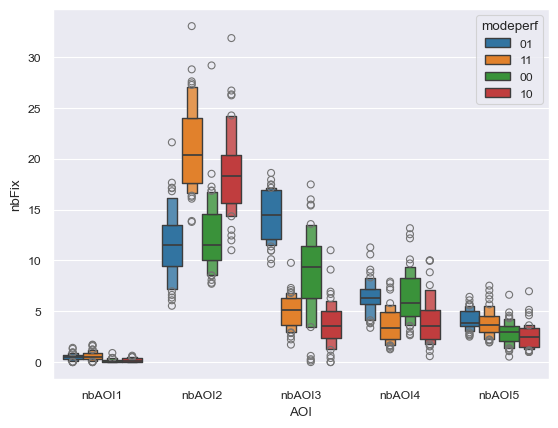

                 Anova
         F Value  Num DF  Den DF  Pr > F
----------------------------------------
AOI      614.6561 4.0000 284.0000 0.0000
mode       0.0538 1.0000  71.0000 0.8172
AOI:mode 310.0612 4.0000 284.0000 0.0000

#####################################################################
3-WAY ANOVA H1: durFix is impacted by the AOI, the operation mode and the performance (label)
Overall model F( 19, 700) =  300.988, p =  0.0000
                               sum_sq     df           F         PR(>F)
Intercept                2.183388e+04    1.0    0.061067   8.048903e-01
C(mode)                  4.191383e+03    1.0    0.011723   9.138111e-01
C(label)                 9.370909e+04    1.0    0.262093   6.088475e-01
C(AOI)                   3.062833e+08    4.0  214.159174  6.392899e-120
C(mode):C(label)         5.507587e+02    1.0    0.001540   9.687039e-01
C(mode):C(AOI)           1.110887e+08    4.0   77.675348   1.592641e-54
C(label):C(AOI)          3.343879e+07    4.0   23.381

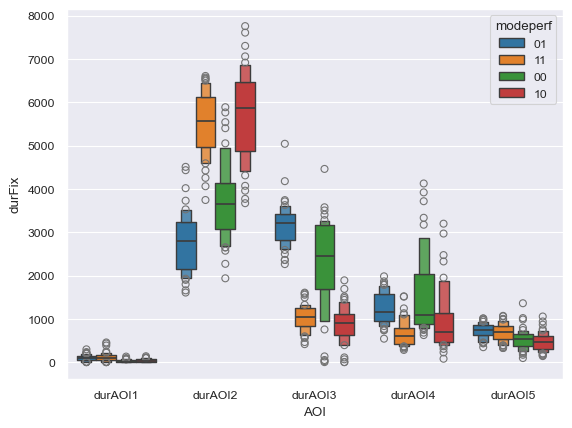

#####################################################################
2-WAY ANOVA H0 : keystrockes is not impacted by the operation mode nor the performance group (label) 
Overall model F( 3, 140) =  312.122, p =  0.0000

                            OLS Regression Results                            
Dep. Variable:                    nav   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           8.69e-62
Time:                        08:42:38   Log-Likelihood:                -371.10
No. Observations:                 144   AIC:                             750.2
Df Residuals:                     140   BIC:                             762.1
Df Model:                           3                                         
Covariance Type:            nonrobust                              

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd, tukeyhsd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

#########################
# Importing data
dfaveraged_data = pd.read_csv('./data/averagedPMPVmode_w10_data.csv')
#########################
# Creating groups "mode x label" for multiple comparison purposes 
dfaveraged_data['modeperf'] = dfaveraged_data['mode'].map(str) + dfaveraged_data['label'].map(str)
dfaveraged_data['submission'] = dfaveraged_data['subject'].map(str) + "_" + dfaveraged_data['mission'].map(str)
print(dfaveraged_data.columns)

#########################
# EXAMPLE 
# ANOVA considering performance group and robot operation mode
# NOTE: we have to assume that each mission is independent here because 
# some participants belong only to one performance group
# (in reality intra-subject sample are dependent)

# 1) We try to verify the hypothesis :
# H0 : HRV is not impacted by the operation mode nor the performance group (label)
# H1 : HRV is impacted by the operation mode or the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H1: HRV is impacted by the operation mode and the performance (label)")
HRVmodel = ols('HRV ~ C(mode)*C(label)', dfaveraged_data).fit()
print(f"Overall model F({HRVmodel.df_model: .0f},{HRVmodel.df_resid: .0f}) = {HRVmodel.fvalue: .3f}, p = {HRVmodel.f_pvalue: .4f}")
print()
print(HRVmodel.summary())
res = sm.stats.anova_lm(HRVmodel, typ= 2)
print()
print(res)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['HRV'], groups=dfaveraged_data['modeperf']).tukeyhsd(alpha=0.05)
print(m_comp)

##################################################
### PLEASE DO THE SAME ANALYSIS WITH HR JUST BELOW

# H0 : HR is not impacted by the operation mode nor the performance group (label)
# H1 : HR is impacted by the operation mode or the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H1: normHR is impacted by the operation mode and the performance (label)")
normHRmodel = ols('HRnorm ~ C(mode)*C(label)', dfaveraged_data).fit()
print(f"Overall model F({normHRmodel.df_model: .0f},{normHRmodel.df_resid: .0f}) = {normHRmodel.fvalue: .3f}, p = {normHRmodel.f_pvalue: .4f}")
print()
print(normHRmodel.summary())
res1 = sm.stats.anova_lm(normHRmodel, typ= 2)
print()
print(res1)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp1 = MultiComparison(dfaveraged_data['HRnorm'], groups=dfaveraged_data['modeperf']).tukeyhsd(alpha=0.05)
print(m_comp1)



#################################################################
### NOW LET'S ANALYSE THE NUMBER OF FIXATIONS IN AOIs (nbFixAOIX)
# 2a) We try to verify the hypothesis : 
# H0 : the number of fixations is not affected by the AOI index nor the operation mode
# H1 : the number of fixations is affected by the AOI index or the operation mode
df = pd.melt(dfaveraged_data[["modeperf","mode","label","submission","subject","nbAOI1","nbAOI2","nbAOI3","nbAOI4","nbAOI5"]], 
             id_vars=["modeperf","submission","mode","label","subject"], 
             value_vars=["nbAOI1","nbAOI2","nbAOI3","nbAOI4","nbAOI5"])
df = df.rename(columns={'value': 'nbFix'})
df = df.rename(columns={'variable': 'AOI'})

# NOTE: we use a repeated measures ANOVA design because data is dependent within subjects and missions
res=AnovaRM(data=df,depvar="nbFix",subject="submission", within=["AOI","mode"]).fit()
print(res)

# 2b) We try to verify the hypothesis : 
# H0 : the number of fixations is not affected by the AOI index nor the operation mode nor the performance label
# H1 : the number of fixations is affected by the AOI index or the operation mode or the performance label
# NOTE: we can't use repeated measure ANOVA design in this case because:
# all the conditions aren't repeated within subjects
sns.boxenplot(x="AOI", y="nbFix", hue="modeperf", linewidth=1, data=df)
print("#####################################################################")
print("3-WAY ANOVA H1: nbFix is impacted by the AOI, the operation mode and the performance (label)")
nbFixModel = ols('nbFix ~ C(mode)*C(label)*C(AOI)', df).fit()
res = sm.stats.anova_lm(nbFixModel, typ= 3)
print(res)

# perform multiple comparison (post-hoc Tukey HSD)
df['modeperfAOI'] = df['mode'].map(str) + "_" + df['label'].map(str) + "_" + df['AOI'].map(str)
m_comp_crossAOIs = MultiComparison(df['nbFix'], groups=df['modeperfAOI']).tukeyhsd(alpha=0.05)
print(m_comp_crossAOIs)
plt.show()

###########################################################################
### PLEASE DO THE SAME ANALYSIS WITH THE AOIs FIXATION DURATIONS JUST BELOW

# 3a) We try to verify the hypothesis : 
# H0 : the AOIs fixation duration is not affected by the AOI index nor the operation mode
# H1 : the AOIs fixation duration is affected by the AOI index or the operation mode
df1 = pd.melt(dfaveraged_data[["modeperf","mode","label","submission","subject","durAOI1","durAOI2","durAOI3","durAOI4","durAOI5"]], 
             id_vars=["modeperf","submission","mode","label","subject"], 
             value_vars=["durAOI1","durAOI2","durAOI3","durAOI4","durAOI5"])
df1 = df1.rename(columns={'value': 'durFix'})
df1 = df1.rename(columns={'variable': 'AOI'})

# NOTE: we use a repeated measures ANOVA design because data is dependent within subjects and missions
res2=AnovaRM(data=df1,depvar="durFix",subject="submission", within=["AOI","mode"]).fit()
print(res2)

# 3b) We try to verify the hypothesis : 
# H0 : the number of fixations is not affected by the AOI index nor the operation mode nor the performance label
# H1 : the number of fixations is affected by the AOI index or the operation mode or the performance label
# NOTE: we can't use repeated measure ANOVA design in this case because:
# all the conditions aren't repeated within subjects
plt.figure()
sns.boxenplot(x="AOI", y="durFix", hue="modeperf", linewidth=1, data=df1)
print("#####################################################################")
print("3-WAY ANOVA H1: durFix is impacted by the AOI, the operation mode and the performance (label)")
durFixModel = ols('durFix ~ C(mode)*C(label)*C(AOI)', df1).fit()
print(f"Overall model F({durFixModel.df_model: .0f},{durFixModel.df_resid: .0f}) = {durFixModel.fvalue: .3f}, p = {durFixModel.f_pvalue: .4f}")
res2 = sm.stats.anova_lm(durFixModel, typ= 3)
print(res2)

# perform multiple comparison (post-hoc Tukey HSD)
df1['modeperfAOI'] = df1['mode'].map(str) + "_" + df1['label'].map(str) + "_" + df1['AOI'].map(str)
m_comp_crossAOIs2 = MultiComparison(df1['durFix'], groups=df1['modeperfAOI']).tukeyhsd(alpha=0.05)
print(m_comp_crossAOIs2)
plt.show()


# ####################################################################################
# ### PLEASE DO THE SAME ANALYSIS WITH THE KEYSTROKES AND CLICKS (nav,tank) JUST BELOW



# H0 : keystrockes is not impacted by the operation mode nor the performance group (label)
# H1 : keystrockes is impacted by the operation mode or the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H0 : keystrockes is not impacted by the operation mode nor the performance group (label) ")
NAVmodel = ols('nav ~ C(mode)*C(label)', dfaveraged_data).fit()
print(f"Overall model F({NAVmodel.df_model: .0f},{NAVmodel.df_resid: .0f}) = {NAVmodel.fvalue: .3f}, p = {NAVmodel.f_pvalue: .4f}")
print()
print(NAVmodel.summary())
res4 = sm.stats.anova_lm(NAVmodel, typ= 2)
print()
print(res4)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['nav'], groups=dfaveraged_data['modeperf']).tukeyhsd(alpha=0.05)
print(m_comp)

# H0 : clicks is not impacted by the operation mode nor the performance group (label)
# H1 : clicks is impacted by the operation mode or the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H0 : clicks is not impacted by the operation mode nor the performance group (label) ")
Tankmodel = ols('tank ~ C(mode)*C(label)', dfaveraged_data).fit()
print(f"Overall model F({Tankmodel.df_model: .0f},{Tankmodel.df_resid: .0f}) = {Tankmodel.fvalue: .3f}, p = {Tankmodel.f_pvalue: .4f}")
print()
print(Tankmodel.summary())
res5 = sm.stats.anova_lm(Tankmodel, typ= 2)
print()
print(res5)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['tank'], groups=dfaveraged_data['modeperf']).tukeyhsd(alpha=0.05)
print(m_comp)





# ## plotting operation mode x nav keystrokes grouped by the performance label
# plotting_data_per_perfgroup(dfaveraged_data, "mode", "nav")
# plt.show()
# #plt.clf()

# ## plotting operation mode x tank keystrokes grouped by the performance label
# plotting_data_per_perfgroup(dfaveraged_data, "mode", "tank")
# plt.show()
# #plt.clf()

# H0 : nbAOI1 is not impacted by the operation mode nor the performance group (label)
# H1 : nbAOI1 is impacted by the operation mode or the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H1: nbAOI1 is impacted by the operation mode and the performance (label)")
normHRmodel = ols('nbAOI1 ~ C(mode)*C(label)', dfaveraged_data).fit()
print(f"Overall model F({normHRmodel.df_model: .0f},{normHRmodel.df_resid: .0f}) = {normHRmodel.fvalue: .3f}, p = {normHRmodel.f_pvalue: .4f}")
print()
print(normHRmodel.summary())
res1 = sm.stats.anova_lm(normHRmodel, typ= 2)
print()
print(res1)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp1 = MultiComparison(dfaveraged_data['nbAOI1'], groups=dfaveraged_data['modeperf']).tukeyhsd(alpha=0.05)
print(m_comp1)


In [6]:

# ANALYSE DE L'IMPACT DU MODE PUIS DE LA PERFORMANCE SUR LES MARQUEURS

# H0 : keystrockes is not impacted by the operation mode 
# H1 : keystrockes is impacted by the operation mode
print("#####################################################################")
print("2-WAY ANOVA H0 : keystrockes is not impacted by the operation mode ")
NAVmodel = ols('nav ~ C(mode)', dfaveraged_data).fit()
print(f"Overall model F({NAVmodel.df_model: .0f},{NAVmodel.df_resid: .0f}) = {NAVmodel.fvalue: .3f}, p = {NAVmodel.f_pvalue: .4f}")
print()
print(NAVmodel.summary())
res4 = sm.stats.anova_lm(NAVmodel, typ= 2)
print()
print(res4)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['nav'], groups=dfaveraged_data['mode']).tukeyhsd(alpha=0.05)
print(m_comp)

# H0 : clicks is not impacted by the operation mode 
# H1 : clicks is impacted by the operation mode
print("#####################################################################")
print("2-WAY ANOVA H0 : clicks is not impacted by the operation mode ")
Tankmodel = ols('tank ~ C(mode)', dfaveraged_data).fit()
print(f"Overall model F({Tankmodel.df_model: .0f},{Tankmodel.df_resid: .0f}) = {Tankmodel.fvalue: .3f}, p = {Tankmodel.f_pvalue: .4f}")
print()
print(Tankmodel.summary())
res5 = sm.stats.anova_lm(Tankmodel, typ= 2)
print()
print(res5)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['tank'], groups=dfaveraged_data['mode']).tukeyhsd(alpha=0.05)
print(m_comp)

# H0 : keystrockes is not impacted by the performance group (label)
# H1 : keystrockes is impacted by the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H0 : keystrockes is not impacted by the performance group (label) ")
NAVmodel = ols('nav ~ C(label)', dfaveraged_data).fit()
print(f"Overall model F({NAVmodel.df_model: .0f},{NAVmodel.df_resid: .0f}) = {NAVmodel.fvalue: .3f}, p = {NAVmodel.f_pvalue: .4f}")
print()
print(NAVmodel.summary())
res4 = sm.stats.anova_lm(NAVmodel, typ= 2)
print()
print(res4)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['nav'], groups=dfaveraged_data['perf']).tukeyhsd(alpha=0.05)
print(m_comp)

# H0 : clicks is not impacted by the performance group (label)
# H1 : clicks is impacted by the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H0 : clicks is not impacted by the performance group (label) ")
Tankmodel = ols('tank ~ C(label)', dfaveraged_data).fit()
print(f"Overall model F({Tankmodel.df_model: .0f},{Tankmodel.df_resid: .0f}) = {Tankmodel.fvalue: .3f}, p = {Tankmodel.f_pvalue: .4f}")
print()
print(Tankmodel.summary())
res5 = sm.stats.anova_lm(Tankmodel, typ= 2)
print()
print(res5)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['tank'], groups=dfaveraged_data['perf']).tukeyhsd(alpha=0.05)
print(m_comp)

#####################################################################################################################

# 1) We try to verify the hypothesis :
# H0 : HRV is not impacted by the operation mode
# H1 : HRV is impacted by the operation mode 
print("#####################################################################")
print("2-WAY ANOVA H0 : HRV is not impacted by the operation mode ")
HRVmodel = ols('HRV ~ C(mode)', dfaveraged_data).fit()
print(f"Overall model F({HRVmodel.df_model: .0f},{HRVmodel.df_resid: .0f}) = {HRVmodel.fvalue: .3f}, p = {HRVmodel.f_pvalue: .4f}")
print()
print(HRVmodel.summary())
res = sm.stats.anova_lm(HRVmodel, typ= 2)
print()
print(res)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['HRV'], groups=dfaveraged_data['mode']).tukeyhsd(alpha=0.05)
print(m_comp)

# 1) We try to verify the hypothesis :
# H0 : HRV is not impacted by the  performance group (label)
# H1 : HRV is impacted by the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H0 : HRV is not impacted by the performance group (label) ")
HRVmodel = ols('HRV ~ C(label)', dfaveraged_data).fit()
print(f"Overall model F({HRVmodel.df_model: .0f},{HRVmodel.df_resid: .0f}) = {HRVmodel.fvalue: .3f}, p = {HRVmodel.f_pvalue: .4f}")
print()
print(HRVmodel.summary())
res = sm.stats.anova_lm(HRVmodel, typ= 2)
print()
print(res)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['HRV'], groups=dfaveraged_data['label']).tukeyhsd(alpha=0.05)
print(m_comp)


#####################################################################
2-WAY ANOVA H0 : keystrockes is not impacted by the operation mode 
Overall model F( 1, 142) =  393.411, p =  0.0000

                            OLS Regression Results                            
Dep. Variable:                    nav   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     393.4
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           9.26e-43
Time:                        08:44:10   Log-Likelihood:                -422.40
No. Observations:                 144   AIC:                             848.8
Df Residuals:                     142   BIC:                             854.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coe

KeyError: 'perf'

#### Draw your conclusions for the task 1.1.2 here:

HRV est impactée par le mode d'opération ou le groupe de performance (FAIL/SUCCESS) (p_value =0.0009)
HRV est impactée plus particulièrement par le groupe de performance et non par le mode d'opération.

HR n'est pas impacté par le mode d'opération ou le groupe de performance (FAIL/SUCCESS) (p_value =0.9195)

Le nombre de fixation est impacté par l'AOI index ou le mode d'opération ou le groupe de performance (p_value = 0.0000...). Une analyse par les graphiques 
plus particulièrement que :
	- Le nombre de fixation est impacté par le groupe de performance dans les AOI 3 et 5.
	- Le nombre de fixation est impacté par le mode d'opération dans les AOI 2, 3 et 4.

La durée de fixation est impactée par l'AOI index ou le mode d'opération ou le groupe de performance (p_value = 0.0000...). Une analyse par les graphiques 
plus particulièrement que :
	- La durée de fixation n'est pas impactée par le groupe de performance peu importe l'AOI concernée.
	- La durée de fixation est impactée par le mode d'opération dans les AOI 2, 3 et 4.

Les clicks (sur le réservoir d'eau) sont impactés par le mode d'opération (AUTO/MANUEL) ou le groupe de performance (FAIL/SUCCESS) (p_value =0.0000...).
Les clicks sont impactés en particulier par le mode d'opération (p_value = 0.0000...) et non par le groupe de performance (p_value=0.1262). 

Les keystrokes (barre espace) sont impactés par le mode d'opération (AUTO/MANUEL) ou le groupe de performance (FAIL/SUCCESS) (p_value =0.0000...).
Les keystrokes sont impactés par le monde d'opération (p_value = 0.0000...) et également par le groupe de performance (p_value = 0.0102).

**Task 1.1.3: Based on the results obtained above, define the subdataset to be considered for classification**

**Remark 1 :** note that the data file *df10labeled_data* will be used in this exercise, where all 10-second time windows are listed. The goal here is to produce a prediction for each sample built on a 10-second time window

In [8]:
import pandas as pd
import numpy as np

#########################################################
# importing data
df10labeled_data = pd.read_csv('./data/df10labeled_data.csv')
print(df10labeled_data)

#########################################################
## Next, we propose to remove  data samples related to some subjects from the training data set:
## note that it allows to verify that the framework is working with new subjects never used for 
## learning POMDP parameters.

## EXAMPLE: we exclude here subjects 19, 23, 33 and 38
subdf10labeled_data = df10labeled_data.loc[(df10labeled_data["subject"]!=19)&
                                           (df10labeled_data["subject"]!=23)&
                                           (df10labeled_data["subject"]!=33)&
                                           (df10labeled_data["subject"]!=40)]
print(subdf10labeled_data)

##########################################################
## EXAMPLE of feature selection 
## please select features according to your previous statistical analysis !!
subdataset = subdf10labeled_data.loc[:, ['HRV', 'HRnorm', 'mode', 'nav', 'tank',  'nbAOI2', 'nbAOI3',  'nbAOI4',  'space', 'label']]

print(subdataset)

      subject  mission  mode         HR       HRV   nav  tank  space  trees  \
0        19.0      1.0   0.0  72.568940 -0.066819  14.0   0.0    0.0    0.0   
1        19.0      1.0   0.0  74.229865 -0.087446  18.0   2.0    0.0    0.0   
2        19.0      1.0   1.0  73.304826 -0.070724   9.0   5.0    0.0    0.0   
3        19.0      1.0   1.0  69.962687 -0.050697   0.0   8.0    0.0    0.0   
4        19.0      1.0   1.0  70.771408 -0.076950   0.0   7.0    0.0    1.0   
...       ...      ...   ...        ...       ...   ...   ...    ...    ...   
3586     40.0      4.0   1.0  69.767442 -0.041904   0.0  24.0    0.0    0.0   
3587     40.0      4.0   0.0  67.046597 -0.043276  12.0   8.0    0.0    0.0   
3588     40.0      4.0   0.0  69.549090 -0.044936  10.0  14.0    0.0    0.0   
3589     40.0      4.0   0.0  72.245635 -0.045260   6.0   8.0    1.0    0.0   
3590     40.0      4.0   1.0  71.564885 -0.048838   2.0   9.0    0.0    0.0   

      nbAOI1  ...  nbAOI4  nbAOI5  durAOI1   durAOI

**Task 1.1.4 Classifier Setup**

The goal here is to find the best classifier (i.e. the most accurate) to predict the human operator's mental state.

Thus, we propose to:
1. split the dataset into training and testing sets
2. choose a classifier according to the sklearn map (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
2. define a pipeline (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
3. select the hyper-paremeters to be cross-validated as well as the associated candidates for each hyper-parameter
4. define the grid-search cross-validation classifier
5. train it using the fit method on the training set
6. evaluate the resulting classifier on the testing set
7. go back to step 2



In [10]:
#### PLEASE PUT YOUR CODE HERE

### import libraries

from sklearn.utils import all_estimators
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

### split dataset into training and testing sets


v = subdataset.values
X = v[:, 0:9]
y = v[:,-1]
print (X.shape)
print ("gogo")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
print (X_train.shape)

### define classifier
### define pipeline
### define hyper-parameters and associated candidates
### define the grid search cross-validation classifier
### train using the fit method
### evaluate the classifier and print results
 #print(classification_report(label_true, label_pred))

(2797, 9)
gogo
(1678, 9)


Premier classifieur : SVC

In [11]:
clf1 = SVC()
clf1.fit(X_train, y_train)
score1 = clf1.score(X_test, y_test)
print("Score SVC: ", score1)

Score SVC:  0.7470956210902592


Second classifieur : Gaussien

In [12]:
clf2 = GaussianProcessClassifier (1.0 * RBF(1.0))

# meta_parameters={'kernel__k1' : [RBF(3.0)],
#                 'max_iter_predict' : [100,400,600],
#                 'multi_class' : ["one_vs_rest", "one_vs_one"],
#                 'warm_start' : ['False','True'],
#                 'n_restarts_optimizer' : [0,3,6]
#                 }
# opt_clf2 = GridSearchCV(clf2, meta_parameters, scoring = 'roc_auc')


opt_clf2 = GridSearchCV(clf2, meta_parameters, scoring = 'roc_auc')
opt_clf2.fit(X_train, y_train)
score2opt = opt_clf2.score(X_test, y_test)*100 #résultat %
print("Score Gaussien: ", score2opt)

NameError: name 'meta_parameters' is not defined

Troisième classifieur : Ada

In [13]:
clf3 = AdaBoostClassifier()
meta_parameters = {
              #"base_estimator" :   ["best", "random"],
              "n_estimators": [1, 2,3,15,20,30]
             }
opt_clf3 = GridSearchCV(clf3, meta_parameters, scoring = 'roc_auc')
opt_clf3.fit(X_train, y_train)
print("Best parameters: ", opt_clf3.best_params_)
score3opt = opt_clf3.score(X_test, y_test)*100 #résultat %
print("Score 3 opt: ", score3opt)

Best parameters:  {'n_estimators': 30}
Score 3 opt:  79.87567323507594


Comparaison des classifieurs

In [14]:
from sklearn.metrics import confusion_matrix
#y_pred2 = opt_clf2.predict(X_test)
y_pred3 = opt_clf3.predict(X_test)

#print(classification_report(y_test, y_pred2))
print(classification_report(y_test, y_pred3))

#print(classification_report(label_true, label_pred))

#Score 3 opt:  7.595924609779136e+01
#Score 2 opt:  7.165856134242156e+01

              precision    recall  f1-score   support

         0.0       0.70      0.68      0.69       505
         1.0       0.74      0.76      0.75       614

    accuracy                           0.72      1119
   macro avg       0.72      0.72      0.72      1119
weighted avg       0.72      0.72      0.72      1119


**Task 1.1.5: Extract the confusion matrix of your classifier**

**Remark 1 :** use the notions learnt in the Machine Learning introduction lecture



In [15]:
## Extract the confusion matrix of your classifier here
Matrice_confusion = confusion_matrix(y_test, y_pred3)
print(Matrice_confusion)

[[344 161]
 [148 466]]


**Task 1.1.6: Based on the confusion matrix, please formalize your POMDP observation function hereafter:**

Answer : $Pr(o' \mid s', a) = o(a,s',o')
= \begin{bmatrix} Pr(oe \mid e) & Pr(one \mid e) \\ Pr(one \mid ne) & Pr(oe \mid ne) \end{bmatrix}
= \begin{bmatrix} TPR & FPR \\ FNR & TNR \end{bmatrix}
= \begin{bmatrix} \Phi_{00} & \Phi_{01} \\ \Phi_{10} & \Phi_{11} \end{bmatrix}$,
$\forall a \in A$, 

and with
$\Phi_{00} = 355 $, $\Phi_{01} = 164 $, $\Phi_{10} = 158 $, and $\Phi_{11} = 444 $.


### Task 1.2 : Define the POMDP reward function

An optimal policy maximizes the sum of rewards over time. 
The reward function therefore defines the criterion that the artificial agent seeks to optimize. 
Here we would like to define this reward function.

Since the goal of the task is to put out as many fires as possible,
the reward should be defined as the number of tree extinguished
during the 10-second time window denoted by $R_t$: the value function is then:

$ V = \mathbb{E}\big[ \sum_t R_t \big]
= \mathbb{E} \Big[ \sum_t  \mathbb{E} \big[ R_t \mid s_t, a_t \big] \Big]
= \mathbb{E} \Big[ \sum_t  r(s_t, a_t) \Big]$,

where, $r(s,a) = \mathbb{E} \big[ R_t \mid s_t=s, a_t=a \big]$
is the expectation of the reward given the system state and the agent action,
that could be defined as the reward function.

These expectations ($\forall (s,a) \in S \times A)$ can be easily approximated using the dataset,
and the resulting averages can then be used to define the reward function in practice.
To this end, it is important to analyse again our averaged dataset. 


**1.2.1. Given the state and action spaces defined above, please formalize your reward function:**


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

##################################################
## importing data
dfaveraged_data = pd.read_csv('./data/averagedPMPVmode_w10_data.csv')

##################################################
## excluding the same participants as before
subdfaveraged_data = dfaveraged_data.loc[(dfaveraged_data["subject"]!=19)&
                                           (dfaveraged_data["subject"]!=23)&
                                           (dfaveraged_data["subject"]!=33)&
                                           (dfaveraged_data["subject"]!=40)]

##################################################
### PLEASE proceed with computations of the four (4) reward function values
### Remind that expectations can be easily approximated using the dataset, 
### and the resulting averages can then be used to define the reward function in practice.
              
# Deux états : engagé, désengagé - Deux modes : manuel, auto
# La fonction de reward est donc une matrice de taille 2*2
Rf = np.zeros((2,2))

mode = dfaveraged_data['mode'].tolist() # Mode d'opération
trees = dfaveraged_data['trees'].tolist()  # nb d'arbres éteints dans les 10 secondes
label = dfaveraged_data['label'].tolist() # Label de performance

print("mode",mode)
print("trees",trees)
print("label",label)

NbManuelEngage, NbAutoEngage, NbManuelDesengage, NbAutoDesengage = 0, 0, 0, 0

# Pour chaque couple (action, état), on compte le nombre d'arbres éteints pour chaque couple 

for k in range(len(mode)):
    print (k)
    if not (mode[k]) and label[k] :
        Rf[0,0]+=trees[k]
        NbManuelEngage+=1
    if not (mode[k]) and not (label[k]):
        Rf[0,1]+=trees[k]
        NbManuelDesengage+=1
    if mode[k] and label[k]:
        Rf[1,0]+=trees[k]
        NbAutoEngage+=1
    if mode[k] and not (label[k]):
        Rf[1,1]+=trees[k]
        NbAutoDesengage+=1
        
# Calcul de la moyenne

Rf[0,0]=Rf[0,0]/NbManuelEngage
Rf[0,1]=Rf[0,1]/NbManuelDesengage
Rf[1,0]=Rf[1,0]/NbAutoEngage
Rf[1,1]=Rf[1,1]/NbAutoDesengage

print(Rf)

mode [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
trees [0.466666666666667, 0.379310344827586, 0.428571428571429, 0.481481481481482, 0.72, 0.558823529411765, 0.538461538461538, 0.515151515151515, 0.473684210526316, 0.4, 0.518518518518518, 0.40625, 0.533333333333333, 0.4, 0.5, 0.387096774193548, 0.321428571428571, 0.333333333333333, 0.3, 0.4, 0.361111111111111, 0.347826086956522, 0.384615384615385, 0.166666666666667, 0.5, 0.344827586206897, 0.606060606060606, 0.222222222222222, 0.588235294117647, 0.52, 0.607142857142857, 0.34375, 0.16, 0.285714285714286, 0.147058823529412, 0.4, 0.114285714285714, 0.625, 0.

In [21]:
print (144/4)
print (mode)
print (trees) 
print (label)

36.0
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[0.466666666666667, 0.379310344827586, 0.428571428571429, 0.481481481481482, 0.72, 0.558823529411765, 0.538461538461538, 0.515151515151515, 0.473684210526316, 0.4, 0.518518518518518, 0.40625, 0.533333333333333, 0.4, 0.5, 0.387096774193548, 0.321428571428571, 0.333333333333333, 0.3, 0.4, 0.361111111111111, 0.347826086956522, 0.384615384615385, 0.166666666666667, 0.5, 0.344827586206897, 0.606060606060606, 0.222222222222222, 0.588235294117647, 0.52, 0.607142857142857, 0.34375, 0.16, 0.285714285714286, 0.147058823529412, 0.4, 0.114285714285714, 0.625, 0.214285

**1.2.2. State a necessary condition on reward function to enable a non trivial POMDP optimization.**

For instance, what is the issue if r(s,manual) = r(s,auto) $\forall s \in S$

Si r(s,manual) = r(s,auto) l'algorithme ne peut pas prendre de décision, car aucun choix semble préférable. Il faut ainsi r(s,manual) != r(s,auto) pour tout s, sinon le choix sera aléatoire.


**1.2.3. Verify with descriptive statistics that the reward function changes with respect to state and action.**

* **Is the score (number of extinguished trees) evolving differently with respect to the robot operation mode and human operator engagement (described by her/his mission performance)?**

[[0.55484027 0.28190895]
 [0.41760041 0.35650864]]


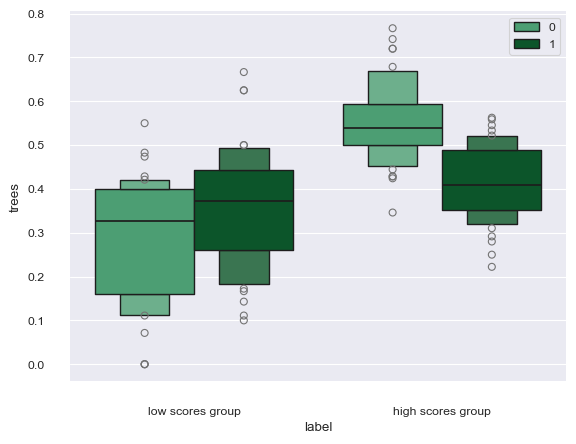

In [24]:
## get a look on how the number of fires extinguished  evolves
## in function of the operation mode and mission performance
## use plotting_data_per_mode function given in the begining of this notebook

# we can also plot the frequency (or the expected number)

print(Rf)
plotting_data_per_mode(dfaveraged_data, "label", "trees")


**1.2.4. Please identify the greedy action $a \in A = \{manual, auto\}$ ("autonomous robot mode" or "manual mode") for each hidden system state $s \in S = \{e, ne\}$ ("engagement" or "no engagement").** 

Describe then the behavior of the artificial agent suggested by this reward function.

Answer:

## Task 2: POMDP model solving and evaluation

### Task 2.1: POMDP model description using the Cassandra format

In this task, please use the Cassandra format to decribe the POMDP model, in a way that the PyPOMDP library can interpret it and solve the problem.

You can use the tiger-2D problem located at *.PyPOMDP/pypomdp/environments/pomdp/Tiger-2D.POMDP* as an example.

Please save the created model in the same folder as the *Tiger-2D.POMDP*, and copy/paste your Cassandra file in the cell bellow:

Answer:

#### EXAMPLE : Firefighter POMDP problem description in Cassandra format 

discount: 0.95

values: reward

states: notengaged engaged 

actions: manu auto

observations: onotengaged oengaged

start: 0.5 0.5

T: *define your transition function*

O: *define your observation function*

R: *define your reward function*




### Task 2.2: POMDP model solving using the customized PyPOMDP library 

To solve the problem using the PyPOMDP library, you need to open a new terminal in the same folder as your jupyter-notebook.

Then, go to the folder .PyPOMDP/pypomdp/ and launch the following command line:

**python main.py pbvi --env Firefighter-2D.POMDP --logfile logFIREpbvi --option offsolve**

where:

pbvi is the algorithm to be used

--env : gives the pomdp file name of your model

--logfile : save the traces of policy computation and simulation (only one simulation)

--option : offline or online solving, or simulate a policy file


*Note a file called **alphavecfile.policy** is created. Please save this file with a more explicit name.*

This file will be useful in the following steps.

In [ ]:
import os
import sys

python_current_env = sys.executable
#print(python_current_env)
current_dir = os.getcwd()
#print(current_dir)
os.chdir('PyPOMDP/pypomdp')
os.system(python_current_env  + " main.py pbvi --env Firefighter-2D.POMDP --logfile logFIREpbvi --option offsolve")
#print(os.getcwd())
os.chdir(current_dir)


### Task 2.3: POMDP model evaluation in simulation

To evaluate the value function and policy obtained, you need to go back to the terminal and launch the following command line:

**python main.py pbvi --env Firefighter-2D.POMDP --policyfile alphavecfile.policy --logfile logFIREpbvi --max_play 60 --option simulate --sim 500**


where:

pbvi is the used algorithm

--env : gives the pomdp file name of your model

--logfile : save the traces of policy computation and simulation (only one simulation)

--option simulate : simulate a policy using the model

--policyfile : your policy file, default: alphavecfile.policy

--max_play :  (60 steps = 10 minutes = 1 mission, following the the 10s-step time assumption)

*Note that you will find a file named **YEAR-MONTH-DAY-H-MIN-S** in the logFile folder ("logFIREpbvi" here). Please have a look at this file to follow the performed simulations. At the end of this file there is a vector with all total rewards observed during the different simulations.*

**Please copy and paste policy simulation average results hereafter (what appears in the terminal):**


In [ ]:
import os
import sys

python_current_env = sys.executable
#print(python_current_env)
current_dir = os.getcwd()
#print(current_dir)
os.chdir('PyPOMDP/pypomdp')
os.system(python_current_env  + " main.py pbvi --env Firefighter-2D.POMDP --policyfile alphavecfile.policy --logfile logFIREpbvi --max_play 60 --option simulate --sim 500")
#print(os.getcwd())
os.chdir(current_dir)

Answer:

### Task 2.4 : Quantitative and qualitative comparison with the random policy used during experiments

In the following, another preprocessed dataset is given: **averagedPMPV_data.csv.** This dataset includes the global_score reached by each participant for each mission.

#### Task 2.4.1: Quantitative comparison

1. Compute the average number of trees extinguished following the random policy used during the experiments
2. Compare this results with the observed results (total_rewards) at least 72 simulations of 60 steps (which is equivalent to 18 participants x 4 mission)
3. Perform a statistical test to verify if the value reached by the optimized policy is significatively greater.

**Remark**: we could also compute the expected value of a random policy on the POMDP model defined. To do this used the following command line:

**python main.py pbvi --env Firefighter-2D.POMDP --logfile logFIREpbvi --max_play 60 --option simulate --sim 500 --random_policy 1**



In [ ]:
import os
import sys

python_current_env = sys.executable
#print(python_current_env)
current_dir = os.getcwd()
#print(current_dir)
os.chdir('PyPOMDP/pypomdp')
os.system(python_current_env  + " main.py pbvi --env Firefighter-2D.POMDP --logfile logFIREpbvi --max_play 60 --option simulate --sim 500 --random_policy 1")
#print(os.getcwd())
os.chdir(current_dir)

**Question:** Is this expected value significantly differing from the one obtained from dataset. If yes, why?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import ttest_ind

## Computing the average number of trees extinghuised following the random policy used during the experiments
#################################
# importing data
dfaveraged_data = pd.read_csv('./data/averagedPMPV_data.csv')
dfaveraged_data.columns
print("Avg. global scores from dataset : ", np.mean(dfaveraged_data["global_score"]))

##################################
### copy the total rewards observed on your 72 simulations here
pomdp_obs_ttrew = [ ]
print("Avg. global scores from simulations : ", np.mean(pomdp_obs_ttrew))

##################################
### perform a statistical test to check the hypothesis:
## H0 : the mean score from dataset is equal to the mean score obtained from policy simulations
## H1 : the mean score from dataset is different to the mean score obtained from policy simulations

### perform a second statistical test to check the hypothesis:
## H0 : the mean score from dataset is higher than the mean score obtained from policy simulations
## H1 : the mean score from dataset is not higher than the mean score obtained from policy simulations



**Draw your conclusion here :** 

Answer:

### Task 2.4.2: Qualitative comparison by performing a replay with collected data

Save the classifier model you have designed. It will be used by a replay runner to rerun a mission.

Our goal is to : 
1. follow the predictor outputs (the POMDP observations)
2. visualize the belief state updates about the human operator's engagement
3. check and describe what the POMDP policy would do given the current belief state

***1. Save your the classifier model***

see https://scikit-learn.org/stable/modules/model_persistence.html

In [ ]:
from joblib import dump, load

#########################################
# save the model named: classifier.joblib



Now, save this classifier.joblib file in "PyPOMDP/pypompd/data/" folder, and

**2. Run the replay program**

- **if you are using your PC with anaconda, you can use a terminal and launch the following script in the folder PyPOMDP/pypomdp:**
    For that, see this command line example:

    **python replay.py pbvi --env Firefighter-2D.POMDP --policyfile alphavecfile.policy --logfile logFIREpbvi --max_play 60 --option replay --sim 4 --expfile data/dfsub_33alldataproc.csv --classif YOUR_CLASSIFIER_MODEL --fnames THE_FEATURES_NAMES_YOU_USED**

    where THE_FEATURES_NAMES_YOU_USED can be for instance 'mode,nav,tank,nbAOI1', and YOUR_CLASSIFIER_MODEL something like 'data/classifier.joblib'. You may get a look in the log folder. 


- **if you are using jupyterhub, you can launch the "replay.ipynb" notebook available in the /PyPOMDP/pypomdp folder**

Note you may choose a subject file (one of the excluded participants for instance) to replay the experiment.

The last logfile details the sequence of symbolic observations predicted from the selected features of the participant.

***3. Describe what the POMDP policy seems to do given the current belief state***

**Draw your conclusions here:**

Answer:

## Task 3 : Refining the POMDP model

### Refine the POMDP model to integrate a visible state variable $s_r$ to indicate the operation mode of the robot as part of the state

In this task, the aim is to expand the state spape $S$ such as: $S = S_h \times S_r$, with $S_h=\{e, ne\}$ and $S_r=\{manu,auto\}$, and to conditionnate the observation function with respect to the action taken.

1. If you observe the replay of experiences, how could you model the fact that when the robot operation mode changes, there is a bigger/lower chance the state of the human operator changes as well ?

2. If this fact is taken into account, it may changes the transition function. So, let's consider now two additionnal expert parameters $\beta$ and $\eta$ that will express the chance we have to obtain for instance : 
$$p(s'=(engaged,manual)|s=(engaged,auto),a=manual) = 1-\beta$$
$$p(s'=(notengaged,manual)|s=(engaged,auto),a=manual) = \beta$$
$$p(s'=(engaged,auto)|s=(engaged,manual),a=auto) = 1-\eta$$
$$p(s'=(notengaged,auto)|s=(engaged,manual),a=auto) = \eta$$

Note the transition function, now a $4x4$ matrix, need to be modified to integrate this new parameters. 

We will assume that the robot operation mode state variable has a deterministic dynamics. It means that when the action $auto$ is chosen, we are $100\%$ sure that the operation mode switches to $auto$.

If you have any problem with the grammar of the POMDP file description, please get a look at https://www.pomdp.org/code/pomdp-file-spec.html

3. Note, you can learn an observation function now conditionned on the action, to be able to integrate this new probabilities through belief state updates, i.e. : $b^o_a(s') \propto p(o|s',a)p(s'|s,a)b(s)$ 

4. Please revise some of the previous tasks in the cells bellow. 

### Task 3.1. Revise task 1.1.3 to separate your dataset in two datasets depending on the robot operation mode 

In [ ]:
import pandas as pd
import numpy as np

##############################
# importing data
df10labeled_data = pd.read_csv('./data/df10labeled_data.csv')
print(df10labeled_data)

##############################
## excluding some subjects as before
## we empirically choose to exclude subjects 19, 23, 33, 38
subdf10labeled_data = df10labeled_data.loc[(df10labeled_data["subject"]!=19)&
                                           (df10labeled_data["subject"]!=23)&
                                           (df10labeled_data["subject"]!=33)&
                                           (df10labeled_data["subject"]!=38)]
print(subdf10labeled_data)

######################################################
# separate the dataset with respect to operation mode
# and select the features to be used for classification

subsubdataset_manu = ?

subsubdataset_auto = ?



### Task 3.2. Revise tasks 1.1.4 and 1.1.5 to train a classifier per dataset and then, extract their confusion matrix

In [ ]:
#### PUT YOUR CODE HERE

### Task 3.3. Revise task 2.1 to define your POMDP in the Cassandra file format

Note you may probably have different transition and observations functions depending on the action manu/auto.

Copy and paste your POMDP model in Cassandra format hereafter:


### Firefighter.4D.POMDP

discount: 0.95

values: reward

states: notengagedmanu engagedmanu notengagedauto engagedauto 

actions: manu auto

observations: onotengaged oengaged

start: 0.25 0.25 0.25 0.25

...

### Task 3.4. Revise tasks 2.2 and 2.3

#### Copy and paste the used command lines for POMDP solving and the results obtained with 500 simulations for this new POMDP model and optimized policy


Answer:

## Champions' Question:

**Is this new POMDP model presenting a significant improvement according to the expected cumulated rewards when compared with the random policy used during experiments?**


**Is this new POMDP model presenting a significant improvement according to the expected cumulated rewards when compared with the policy optimized based on the previous POMDP model?**

Answer: